# Examen Interciclo
## Autor: Yandry Romero

•	Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:

- Obtener datos de tendencia de twitter o facebook(crawler o webscraping), para ello se puede obtener a través del API [4].

# Predicción usando regresión

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import simpy
import random
import matplotlib.pyplot as pp
import numpy as np

%matplotlib inline

In [2]:
data1 = pd.read_csv('data_cruda.csv')
data1 = data1.fillna(0)
data1.head()

,username,comment,reply,retweet,like
0,Presidencia ECU,"El presidente \n@LassoGuillermo\n, durante su ...",166,556,4.5K
1,Guillermo Lasso,Hoy tuve la oportunidad de dialogar con \n@leo...,581,874,4.2K
2,Guillermo Lasso,Fue un honor recibir a representantes de \n@US...,207,638,2.8K
3,Guillermo Lasso,Esta noche mantuvimos la primera reunión del C...,368,1.1K,5.8K
4,Guillermo Lasso,El Decreto que elimina los registros de crédit...,256,875,3.5K


# Preparación de los datos

In [3]:
def convert_str_to_number(x):
    total_stars = 0
    num_map = {'K':1000, 'M':1000000, 'B':1000000000}
        
    if not x.isdigit():
        if len(x) > 1:
            total_stars = float(x[:-1]) * num_map.get(x[-1].upper(), 1)
    else:
        total_stars = int(x)
    return int(total_stars)

In [4]:
# convertir formato 2.3k a 2300
data1['like']=[convert_str_to_number(i) for i in data1['like']]
data1['retweet']=[convert_str_to_number(i) for i in data1['retweet']]
data1['reply']=[convert_str_to_number(i) for i in data1['reply']]
data1

,username,comment,reply,retweet,like
0,Presidencia ECU,"El presidente \n@LassoGuillermo\n, durante su ...",166,556,4500
1,Guillermo Lasso,Hoy tuve la oportunidad de dialogar con \n@leo...,581,874,4200
2,Guillermo Lasso,Fue un honor recibir a representantes de \n@US...,207,638,2800
3,Guillermo Lasso,Esta noche mantuvimos la primera reunión del C...,368,1100,5800
4,Guillermo Lasso,El Decreto que elimina los registros de crédit...,256,875,3500
...,...,...,...,...,...
245,Guillermo Lasso,En 6 días tenemos una responsabilidad históric...,138,574,2100
246,Guillermo Lasso,Las 4 claves de mi Plan de Gobierno: fortalece...,134,464,1200
247,Guillermo Lasso,"Desde la Presidencia, trabajaremos con todas l...",70,184,757
248,Guillermo Lasso,El primer deber del Estado es proteger la vida...,63,205,601


In [5]:
data1.comment = data1.comment.str.replace(r'\n','')
data1

,username,comment,reply,retweet,like
0,Presidencia ECU,"El presidente @LassoGuillermo, durante su prim...",166,556,4500
1,Guillermo Lasso,Hoy tuve la oportunidad de dialogar con @leopo...,581,874,4200
2,Guillermo Lasso,Fue un honor recibir a representantes de @USem...,207,638,2800
3,Guillermo Lasso,Esta noche mantuvimos la primera reunión del C...,368,1100,5800
4,Guillermo Lasso,El Decreto que elimina los registros de crédit...,256,875,3500
...,...,...,...,...,...
245,Guillermo Lasso,En 6 días tenemos una responsabilidad históric...,138,574,2100
246,Guillermo Lasso,Las 4 claves de mi Plan de Gobierno: fortalece...,134,464,1200
247,Guillermo Lasso,"Desde la Presidencia, trabajaremos con todas l...",70,184,757
248,Guillermo Lasso,El primer deber del Estado es proteger la vida...,63,205,601


In [6]:
data1=data1.assign(countWords=6)
data1.countWords = data1.comment.apply(lambda x: len(str(x).split(" ")))
data1

,username,comment,reply,retweet,like,countWords
0,Presidencia ECU,"El presidente @LassoGuillermo, durante su prim...",166,556,4500,33
1,Guillermo Lasso,Hoy tuve la oportunidad de dialogar con @leopo...,581,874,4200,33
2,Guillermo Lasso,Fue un honor recibir a representantes de @USem...,207,638,2800,36
3,Guillermo Lasso,Esta noche mantuvimos la primera reunión del C...,368,1100,5800,40
4,Guillermo Lasso,El Decreto que elimina los registros de crédit...,256,875,3500,32
...,...,...,...,...,...,...
245,Guillermo Lasso,En 6 días tenemos una responsabilidad históric...,138,574,2100,19
246,Guillermo Lasso,Las 4 claves de mi Plan de Gobierno: fortalece...,134,464,1200,31
247,Guillermo Lasso,"Desde la Presidencia, trabajaremos con todas l...",70,184,757,27
248,Guillermo Lasso,El primer deber del Estado es proteger la vida...,63,205,601,26


# Regresión

In [7]:
y = data1['retweet']
x = data1[['reply', 'like','countWords']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

modelR = sm.OLS(y_train, X_train).fit()
predict= modelR.predict(X_test)

In [9]:
preRF=r2_score(y_test,predict)
print("Precisión del modelo: ", preRF)

Precisión del modelo:  0.7836634306172346


In [10]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': predict}) 
df1=df1.round(decimals=5)
df1.head(10)

,Actual,Predicted
142,321,305.97180
6,5700,4118.95228
97,279,281.06163
60,2100,1463.91577
112,1400,911.24304
181,191,273.54778
197,561,536.69014
184,160,342.68271
9,281,381.26641
104,310,424.68286


Text(0.5, 1.0, 'Regresion Multivariable')

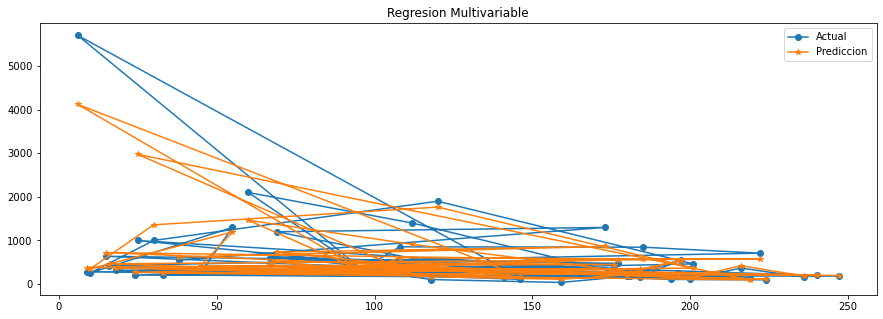

In [11]:
plt.figure(figsize = (15,5))
plt.plot(df1.index, df1.Actual,'o-')
plt.plot(df1.index, df1.Predicted,'*-')
plt.legend(['Actual', 'Prediccion'])
plt.title('Regresion Multivariable')

In [12]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

LinearRegression()

In [13]:
y_pred = regressor.predict(X_test)  
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) 
df1.head()

,Actual,Predicted
142,321,276.159213
6,5700,4199.437307
97,279,293.123724
60,2100,1550.188998
112,1400,919.988617


In [14]:
preRF=r2_score(y_test,y_pred)
print("Precisión del modelo: ", preRF)

Precisión del modelo:  0.7949735144581828


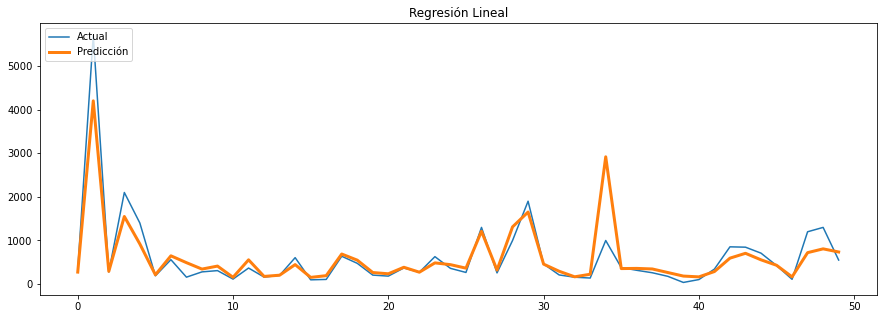

In [15]:
plt.figure(figsize = (15,5))

X = np.arange(len(y_test))
y = data1['retweet'].values.reshape(-1,1)

plt.plot(X, df1['Actual'],'-', label ='Actual')
plt.plot(X, df1['Predicted'], '-', label = 'Predicción', linewidth = 3)

plt.title('Regresión Lineal') 
plt.legend(loc="upper left") 

plt.show()

In [16]:
prediccion = data1[19:20][['reply', 'like','countWords']]
print('Predicción de cuántas veces será compartido un post/twitter:', regressor.predict(prediccion))
data1[19:20]

Predicción de cuántas veces será compartido un post/twitter: [386.75445415]


,username,comment,reply,retweet,like,countWords
19,Guillermo Lasso,A las 10h30 los invito a ser parte de la entre...,153,371,1700,35


# Simulación Sympy

La simulación la vamos a realizar en un recinto electoral de la ciudad de Piñas ubicado en la ESCUELA DE EDUCACION BASICA CRISTOBAL COLON en la cual asiten a votar 3500 personas y cuenta con 10 juntas receptoras del voto, primero vamos a simular la primera dosis.

Estos datos los obtenemos del siguiente enlace: http://portal.cne.gob.ec/images/d/2021/Distributivo_recintos_e/Distributivo_de_recintos_final_2021.xls

In [30]:
NUM_VACUNAS = 100
NUM_JUNTAS = 10
NUM_PERSONAS = 3500
TIEMPO_SIMULACION = 340
NUM_PERSONAL = 5
NUM_REGISTRO = 2
NUM_E_CERTIFICADO = 2
INTERVALO = 0.00396
persona_vacunadas={}
persona_no_vacunadas={}
DATE_SECOND = datetime.now().strftime('%Y/%m/%d')

In [41]:
 
class vacunacion():
    def __init__(self, entorno,NUM_JUNTAS):
        self.entorno= entorno
        self.NUM_JUNTAS = simpy.Resource(entorno, NUM_JUNTAS)
    
    def llega_recinto(self,tiempo):
        yield self.entorno.timeout(tiempo)
        
    def llegada_mesa(self,tiempo):
        yield self.entorno.timeout(tiempo)
    
    def realiza_examen(self,tiempo):
        yield self.entorno.timeout(tiempo)
        
    def vacunacion_persona(self, tiempo):
        yield self.entorno.timeout(tiempo)
        
    def espera_sintomas(self,tiempo):
        yield self.entorno.timeout(tiempo)
        
    def espera_certificado(self,tiempo):
        yield self.entorno.timeout(tiempo)
        
    def segunda_dosis(self,tiempo):
        yield self.env.timeout(tiempo)
    
    def salir_recinto(self,tiempo):
        yield self.entorno.timeout(tiempo)
        
    def proceso_vacunacion(self, persona):
        print('La {} Llega al recinto {:,.6f}'.format(persona,self.entorno.now))
        espera = self.entorno.now
        with self.NUM_JUNTAS.request() as mesa:
            yield mesa
            tiempo_llegada = random.uniform(1,20)
            print('La {} Se traslada a la mesa {:,.6f}'.format(persona,self.entorno.now))
            yield self.entorno.process(self.llegada_mesa(tiempo_llegada))
            print('La {} Se traslada a la mesa {:,.6f}'.format(persona,self.entorno.now))
            tiempo_espera = self.entorno.now - espera
            tiempo_examen = 20
            yield self.entorno.process(self.realiza_examen(tiempo_examen))
            print('La {} Se realizo revision medica {:,.6f}'.format(persona,self.entorno.now))
            print('La {} Se traslada a vacunacion {:,.6f}'.format(persona,self.entorno.now))
            tiempo_vacuna = random.randint(5,10)
            yield self.entorno.process(self.vacunacion_persona(tiempo_vacuna))
            print('La {} Se termino de vacunar {:,.6f}'.format(persona,self.entorno.now))
            tiempo_espera_sintomas = 1.2
            print('La {} Se termino tiempo de reposo {:,.6f}'.format(persona,self.entorno.now))
            yield self.entorno.process(self.espera_sintomas(tiempo_espera_sintomas))
            tiempo_certificado = random.randint(1, 5)
            yield self.entorno.process(self.espera_certificado(tiempo_certificado))
            print('La {} Se Entrego el certificado {:,.6f}'.format(persona,self.entorno.now))
            tiempo_salir= random.randint(1,5)
            segunda = datetime.strftime(datetime.strptime(DATE_SECOND, '%Y/%m/%d')+dt.timedelta(days=21), '%Y/%m/%d')
            print('A la {} se asigna la siguiente dosis {}'.format(persona,segunda))
            yield self.entorno.process(self.salir_recinto(tiempo_salir))
            print('La {} Se termino el proceso {:,.6f}'.format(persona,self.entorno.now))
            
class Simulacion():

    def __init__(self,NUM_VACUNAS):
        self.NUM_VACUNAS = NUM_VACUNAS
        self.nombre_persona = 'persona_{}'
        

    def ejecutar_simulacion(self,entorno,INTERVALO,NUM_JUNTAS):
        vacun = vacunacion(entorno, NUM_JUNTAS)
        self.iniciar_persona(entorno, vacun)

        while True:
            if(entorno.now<0.33):
                estado = random.randint(1,100)
                if (estado < 10) :
                    persona_no_vacunadas[entorno.now] = persona_no_vacunadas[entorno.now] + 1 if entorno.now in persona_no_vacunadas else  1
                else:
                    persona_vacunadas[entorno.now] = persona_vacunadas[entorno.now] + 1 if entorno.now in persona_vacunadas else 1
                    yield entorno.timeout(random.uniform(INTERVALO-0.00132,INTERVALO+0.00132))
                    self.NUM_VACUNAS+=1
                    yield entorno.process(vacun.proceso_vacunacion(self.nombre_persona.format(self.NUM_VACUNAS)))
                 
            if(entorno.now<31):
                 yield entorno.timeout(random.uniform(INTERVALO-0.00132,INTERVALO+0.00132))


    def iniciar_persona(self,entorno,procVacu):
        for i in range(self.NUM_VACUNAS):
            estado = random.randint(1,100)
            if (estado < 10) :
                persona_no_vacunadas[entorno.now] = persona_no_vacunadas[entorno.now] + 1 if entorno.now in persona_no_vacunadas else  1
            else:
                persona_vacunadas[entorno.now] = persona_vacunadas[entorno.now] + 1 if entorno.now in persona_vacunadas else 1
                entorno.process(procVacu.proceso_vacunacion(self.nombre_persona.format(i)))

In [42]:
entorno = simpy.Environment()
simulacion = Simulacion(NUM_VACUNAS)
entorno.process(simulacion.ejecutar_simulacion(entorno, NUM_JUNTAS, INTERVALO))
entorno.run(until=TIEMPO_SIMULACION)

La persona_0 Llega al recinto 0.000000
La persona_1 Llega al recinto 0.000000
La persona_2 Llega al recinto 0.000000
La persona_3 Llega al recinto 0.000000
La persona_4 Llega al recinto 0.000000
La persona_5 Llega al recinto 0.000000
La persona_6 Llega al recinto 0.000000
La persona_7 Llega al recinto 0.000000
La persona_8 Llega al recinto 0.000000
La persona_9 Llega al recinto 0.000000
La persona_10 Llega al recinto 0.000000
La persona_11 Llega al recinto 0.000000
La persona_12 Llega al recinto 0.000000
La persona_13 Llega al recinto 0.000000
La persona_14 Llega al recinto 0.000000
La persona_15 Llega al recinto 0.000000
La persona_16 Llega al recinto 0.000000
La persona_17 Llega al recinto 0.000000
La persona_18 Llega al recinto 0.000000
La persona_19 Llega al recinto 0.000000
La persona_21 Llega al recinto 0.000000
La persona_22 Llega al recinto 0.000000
La persona_23 Llega al recinto 0.000000
La persona_24 Llega al recinto 0.000000
La persona_25 Llega al recinto 0.000000
La persona

In [20]:
print("Personas Vacunadas: ")
print(persona_vacunadas)
print("`Personas No Vacunadas: ")
print(persona_no_vacunadas)

Personas Vacunadas: 
{0: 87}
`Personas No Vacunadas: 
{0: 14}


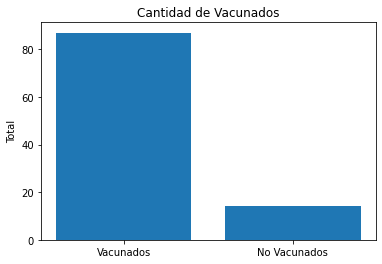

In [21]:
datosNo=sorted(persona_no_vacunadas.items()) # Ordenamos los datos
xn, yn =zip(*datosNo)
datos=sorted(persona_vacunadas.items()) # Ordenamos los datos
x, y =zip(*datos)
personas = ['Vacunados', 'No Vacunados']
cantidad = [sum(y),sum(yn)]
fig, ax = plt.subplots()
ax.set_ylabel('Total')
ax.set_title('Cantidad de Vacunados')
plt.bar(personas, cantidad)
plt.show()